In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

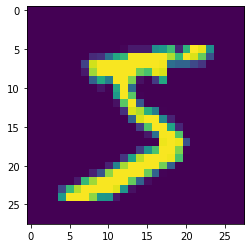

In [4]:
plt.figure()
plt.imshow(x_train[0])
plt.show()

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2888 - acc: 0.9156
Epoch 2/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1400 - acc: 0.9578
Epoch 3/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1048 - acc: 0.9679
Epoch 4/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0852 - acc: 0.9737
Epoch 5/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0727 - acc: 0.9770
10000/10000 - 0s - loss: 0.0744 - acc: 0.9771


[0.0743602165108081, 0.9771]

In [7]:
test_img = x_train[0]

def get_label_confidence(image, model):
    pr = model.predict(image.reshape(1, 28, 28))
    image_class = model.predict_classes(image.reshape(1, 28, 28))
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))
   
get_label_confidence(test_img, model)

'Predicted 5 : 0.9976298'

In [8]:
image_probs = model.predict(test_img.reshape(1, 28, 28))
label = tf.one_hot(5, image_probs.shape[-1])
print(label)

Tensor("one_hot:0", shape=(10,), dtype=float32)


In [9]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model2.fit(x_train, y_train, epochs=5)
model2.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.2961 - acc: 0.9142
Epoch 2/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1447 - acc: 0.9574
Epoch 3/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1070 - acc: 0.9675
Epoch 4/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0874 - acc: 0.9732
Epoch 5/5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0747 - acc: 0.9763
10000/10000 - 0s - loss: 0.0833 - acc: 0.9745


[0.08329807162545622, 0.9745]

In [80]:
sess = K.get_session()
x = x_train[0]
x = np.reshape(x, (1, 28, 28))
x_adv = x
x_noise = np.zeros_like(x)

In [81]:
model1_initial = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_initial = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Initial Results')
print(model1_initial)
print(model2_initial)

Initial Results
Model 1 - Predicted 5 : 0.9976298
Model 2 - Predicted 5 : 0.9938952


In [82]:
# Set variables
epochs = 21
epsilon = 0.01
true_class = 5
target_class = 2
prev_probs = []
prev_probs2 = []

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 10)
    true = K.one_hot(true_class, 10)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1 * K.categorical_crossentropy(target, model.output) 
    loss2 = -1 * K.categorical_crossentropy(true, model2.output)
    grads = K.gradients(loss, model.input)
    grads2 = K.gradients(loss2, model2.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0]) + K.sign(grads2[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon * delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x, model2.input:x})
    preds = model.predict(x_adv)
    preds2 = model2.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])
    prev_probs2.append(preds2[0][target_class])

    if i%10 == 0:
        print('Epoch:', i, '\t', 'Model1', '\t', 'Targeted', target_class, ':', preds[0][target_class], 
              '\t', get_label_confidence(x_adv, model))
        print('Epoch:', i, '\t', 'Model2', '\t', 'Targeted', target_class, ':', preds2[0][target_class],
             '\t', get_label_confidence(x_adv, model2))
        

Epoch: 0 	 Model1 	 Targeted 2 : 2.696253e-06 	 Predicted 5 : 0.9979231
Epoch: 0 	 Model2 	 Targeted 2 : 1.1489619e-07 	 Predicted 5 : 0.9978240
Epoch: 10 	 Model1 	 Targeted 2 : 0.3752431 	 Predicted 5 : 0.6170026
Epoch: 10 	 Model2 	 Targeted 2 : 0.0005942346 	 Predicted 5 : 0.9993491
Epoch: 20 	 Model1 	 Targeted 2 : 0.9927099 	 Predicted 2 : 0.9927099
Epoch: 20 	 Model2 	 Targeted 2 : 0.010080692 	 Predicted 5 : 0.9895704


In [86]:
model1_final = 'Model 1 - ' + get_label_confidence(x_adv, model)
model2_final = 'Model 2 - ' + get_label_confidence(x_adv, model2)
print('Final Results')
print(model1_final)
print(model2_final)

Final Results
Model 1 - Predicted 2 : 0.9927099
Model 2 - Predicted 5 : 0.9895704


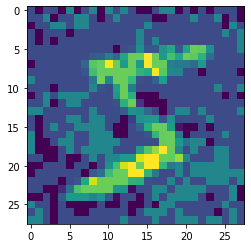

In [87]:
plt.imshow(x_adv[0])
plt.show()

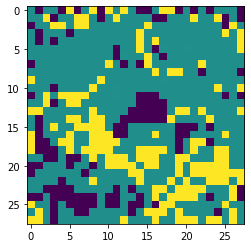

In [88]:
plt.imshow(x_adv[0] - x[0])
plt.show()

In [91]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile model using accuracy to measure model performance
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
model3.fit(x_train, y_train, epochs=5)
model3.evaluate(x_test,  y_test, verbose=2)

ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (60000, 28, 28)